# GLISS Tutorial

This tutorial demonstrates how to run GLISS, using simulated data with ground truth.

## Load Common Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import display
import sys
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

The Python source code of GLISS is under the folder `src/`, so we include the path here.

The folder `data/` includes some files and temporary outputs for this tutorial.

In [2]:
sys.path.insert(0,'src')

# Selecting SV Genes from SGE Data


### Load and Visualize Data
The coordinates and the gene expression matrix are from a simulated SGE dataset

In [3]:
from io_utils import load_data_from_file
from general_utils import norm_mtx
from plot_utils import plot_multiple_scatter_continuous

locs = load_data_from_file('data/sge_locs_2d.csv', 'csv')
expr_data = load_data_from_file('data/sge_gex_mtx.csv', 'csv')
data_norm = norm_mtx(expr_data) # normalize each gene
data_norm = data_norm.values # convert from pd.dataframe to np matrix
print('Gene expression matrix dimension: {}'.format(data_norm.shape))

Gene expression matrix dimension: (1045, 200)


### Plot 4 representative columns of the gene expression matrix (Optional) 

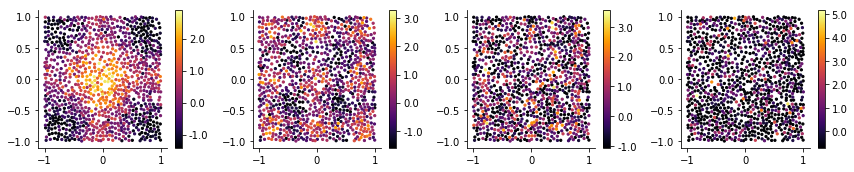

In [4]:
plt_gex = pd.DataFrame(data_norm[:, [0, 30, 50, 180]])
plot_multiple_scatter_continuous(locs, plt_gex)

### Run SV Gene selction with GLISS

- `pvals`: the pvalue of each column of the data matrix
- `rej_idx`: the indices of the selected columns of the data matrix

In [5]:
from main_methods import select_spatial_genes
# paramters
alpha= 0.05 # FDR Level
knn = 8 # number of top neighbors in constructing KNN graph
n_perm = 10000 # number of permutation for p-values
# run SV gene selection with GLISS
pvals, rej_idx = select_spatial_genes(locs, data_norm, 
                         knn=knn, alpha=alpha, n_perm=n_perm)

### Evaluate Power and FDP (Optional) 

- The ground truth was generated with 100 non-null features + 100 null features.
- The non-null features can be divided into 4 resolution groups with 25 features per group.
- With ground truth, we can compute the FDP and Power (with Power further broken down in to 4 resolutions)

In [6]:
from sim_utils import complex_eval_spatial_sim
ground_truth = pd.Series({'n_per_reg': 25, 'n_regs': 4, 
                          'temp': 'cosine', 'seed': 1}, 
                         name='truth')
complex_eval_spatial_sim(ground_truth, rej_idx)

seed                  1
temp             cosine
FDP           0.0131579
Power              0.75
Power-Reg0            1
Power-Reg1            1
Power-Reg2            1
Power-Reg3            0
Name: truth, dtype: object

# Selecting SV Genes from scRNA-seq Data

### Load scRNA-seq data matrix

- Here we assume that the LM genes are given based on the indices 0-5.
- We only visualize the non-LM genes that are order based on ground-truth groupings.

In [7]:
n_lm_genes = 6 # indices 0-5 are the LM genes
mtx = load_data_from_file('data/scrna_gex_mtx.npy', 'npy')
print('scRNA-seq matrix dimension: {}'.format(mtx.shape))
x_star = mtx[:, :n_lm_genes] # lm gene matrix
print('LM gene matrix dimension: {}'.format(x_star.shape))
x = mtx[:, n_lm_genes:] # non-lm gene matrix
print('non-LM gene matrix dimension: {}'.format(x.shape))

scRNA-seq matrix dimension: (1500, 6000)
LM gene matrix dimension: (1500, 6)
non-LM gene matrix dimension: (1500, 5994)


### Select SV genes (using default parameters as SV gene selection for SGE data)

In [8]:
pvals, rej_idx = select_spatial_genes(x_star, x, 
                         knn=knn, alpha=alpha, n_perm=n_perm)

### Infer latent spatial variable

In [9]:
from sim_utils import infer_lambda
new_x = np.concatenate([x_star, x[:,rej_idx]], axis=1)
lam, aux = infer_lambda('graph', new_x, knn=knn)

### Dimension reduction of each gene and embed the genes with UMAP

In [10]:
from spline_utils import setup_basis, spline_fit
import umap
base_args = setup_basis(lam)
print(base_args)
p_fun, gene_mtx = spline_fit(lam, x[:, rej_idx], base_args)

cr(x, knots=(-0.014, 0.012))
Fitted 1000 parameters


In [11]:
uobj = umap.UMAP(random_state=10101)
embedding = uobj.fit_transform(gene_mtx)

/home/users/jjzhu/.ve/aloe/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 7 separate connected components using meta-embedding (experimental)
  n_components


### Cluster the genes into groups from the UMAP gene-to-gene graph

Determine the number of clusters using the gab statistics

In [18]:
from main_methods import graph_spectrum, graph_clustering
from sklearn.cluster import KMeans 
np.random.seed(19)
evals, evecs = graph_spectrum(uobj.graph_)
optimal_kvals = np.argsort(np.diff(evals))[::-1] + 1
clust_k = optimal_kvals[0] 
print(optimal_kvals)
print('Using K = {} for suggested clustering'.format(clust_k))
use_k = optimal_kvals[0] # you can cluster with multiple k values
kmeans = KMeans(n_clusters=use_k, random_state=10).fit(evecs[:, 1 : use_k])
labs = kmeans.labels_ + 1

[ 7  9  8 10 17 19 18 13 14 11 16 12 15  2  4  6  5  1  3]
Using K = 7 for suggested clustering


### Visualize the gene clusters

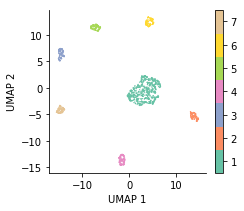

In [30]:
from plot_utils import plot_scatter_discrete
from plot_utils import get_sim_color_map
cids = np.unique(labs)
cols = get_sim_color_map(cids, palette='Set2')
fig, ax = plt.subplots(1,1, figsize=(3.5,3))
plot_scatter_discrete(embedding, labs, 
                              ax=ax, 
                              ms=1.5,
                              alpha=1, 
                              cols=cols)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
plt.show()

### Visualize the expression as a function of latent variable

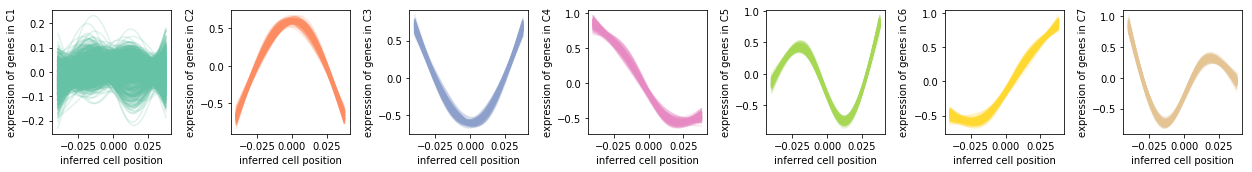

In [33]:
from main_methods import refit_curves
from plot_utils import plot_multi_curves
x_vals, fit_mtx = refit_curves(gene_mtx, base_args, lam)
figsize = (2.5*len(cids), 2.5)
fig, axes = plt.subplots(1, len(cids), figsize=figsize, sharex=True)
for idx, cid in enumerate(cids):
    i = idx 
    ax = axes[i]
    sel = labs == cid
    plot_multi_curves(ax, x_vals, fit_mtx[:,sel], alpha=0.2, color=cols[cid])
    ax.set_ylabel('expression of genes in C{}'.format(cid))
    ax.set_xlabel('inferred cell position')
plt.tight_layout()
plt.show()

## Compare scRNA-seq Results with Ground Truth (Optional)

### Visualize the ground-truth genes identities

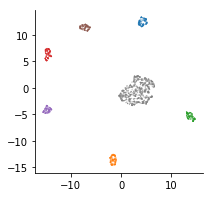

In [15]:
var_df  = load_data_from_file('data/scrna_truth_gene.csv', 'csv')
cell_df = load_data_from_file('data/scrna_truth_cell.csv', 'csv')
lam_true = cell_df['lam_true']
var_labs = var_df.loc[rej_idx]['nn_grp'].values
fig, ax = plt.subplots(1,1, figsize=(3,3))
lut = get_sim_color_map(np.unique(var_df['nn_grp']))
plot_scatter_discrete(embedding, var_labs, 
                              ax=ax, 
                              ms=1.5,
                              alpha=0.6,
                              cols=lut,
                              color_bar=False)
plt.show()

### Load and display other ground truth information

Correlation between true and inferred cell ordering: 0.9941


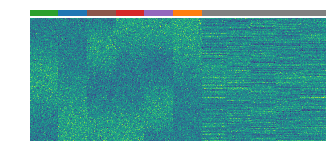

In [17]:
from plot_utils import plot_col_color_heatmap
from sim_utils import get_top_grps
from scipy.stats import spearmanr


# select non-null features
df_1 = var_df.loc[var_df['nn_grp'] >= 0]
order = [2, 0, 5, 3, 4, 1]
df_1_ord = pd.DataFrame()
for grp in order:
    gdf = df_1.loc[df_1['nn_grp']==grp]
    df_1_ord = pd.concat([df_1_ord, gdf])
df_1 = df_1_ord

# select null features correlated to the lm genes
df_2 = var_df.loc[var_df['nn_grp'] == -1]
df_2 = df_2.loc[df_2['lm_corr']]
df_2 = get_top_grps(df_2, 5)
plt_sel_df = pd.concat([df_1, df_2])

def plot_data_mtx(in_mtx, df, lut, val_min=None, val_max=None, lam=[], 
                  short=False, cmap=None):
    in_mtx = in_mtx[:, df['var_id']]
    grp_ids = df['nn_grp']
    if len(lam) > 0:
        sort_idx = np.argsort(lam)
        in_mtx = in_mtx[sort_idx, :]
    plot_col_color_heatmap(in_mtx, grp_ids, lut, short=short, cmap=cmap, cax_visible=False)
plot_data_mtx(x, plt_sel_df, lut, lam=lam_true, cmap='viridis')
cor_val = np.abs(spearmanr(lam, lam_true)[0])
print('Correlation between true and inferred cell ordering: {:.4f}'.format(cor_val))